# THE WORK BELOW REFERS TO 2 SOURCES OF CODE SAMPLE:
1. Sample loading: TensorFlow 2018: 
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb

2. Topic modelling:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
import tensorflow as tf
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 374s 0us/step


In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:
image_paths = list(image_path_to_caption.keys())
random.Random(42).shuffle(image_paths)

# Select the first 5000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it
train_image_paths = image_paths [:5000]
print(len(train_image_paths))

5000


In [ ]:

import pandas as pd
caption_table=pd.DataFrame(list())
caption_table['image_path']=train_image_paths
caption_table['text']=['']*5000
caption_table['image_path'][0]

'/content/train2014/COCO_train2014_000000521200.jpg'

In [ ]:
# create dataframe to store image path - only take the first caption of each image
for i in range(5000):
    caption_table['text'][i]= image_path_to_caption[caption_table['image_path'][i]][0][8:-6]



In [ ]:
import re
# Convert to list
data = caption_table['text'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

['A modern sink and shower stall are visible in this photo.']


In [ ]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])



[['modern', 'sink', 'and', 'shower', 'stall', 'are', 'visible', 'in', 'this', 'photo']]


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['modern', 'sink', 'and', 'shower', 'stall', 'are', 'visible', 'in', 'this', 'photo']


In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
import spacy
import en_core_web_sm
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['modern', 'sink', 'shower', 'stall', 'visible', 'photo']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [ ]:
pip install gensim==3.8.1

     |████████████████████████████████| 24.2 MB 61.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
from gensim.models import ldamodel
from gensim.models import nmf

In [ ]:
coherence_values_lda = []
coherence_values_nmf = []
empty_document_lda=[]
empty_document_nmf=[]

#perplex=[]
model_list_lda = []
model_list_nmf = []
for num_topics in range(10,200,10):
    model_lda = ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42)
    model_list_lda.append(model_lda)
    coherencemodel_lda = CoherenceModel(model=model_lda, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values_lda.append(coherencemodel_lda.get_coherence())
    count_lda=0
    for i, row in enumerate(model_lda[corpus]):
        if row==[]:
            count_lda+=1
    empty_document_lda.append(count_lda)
    #perplex.append(model.log_perplexity(corpus))
    model_nmf =  nmf.Nmf(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42)
    model_list_nmf.append(model_nmf)
    coherencemodel_nmf = CoherenceModel(model=model_nmf, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values_nmf.append(coherencemodel_nmf.get_coherence())
    count_nmf=0
    #check empty cap
    for i, row in enumerate(model_nmf[corpus]):
        if row==[]:
            count_nmf+=1
    empty_document_nmf.append(count_nmf)
    print (num_topics)

10
20
30
40
50
60
70
80
90


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


100


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


110


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


120


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


130


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


140


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


150


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


160


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


170


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


180


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


190


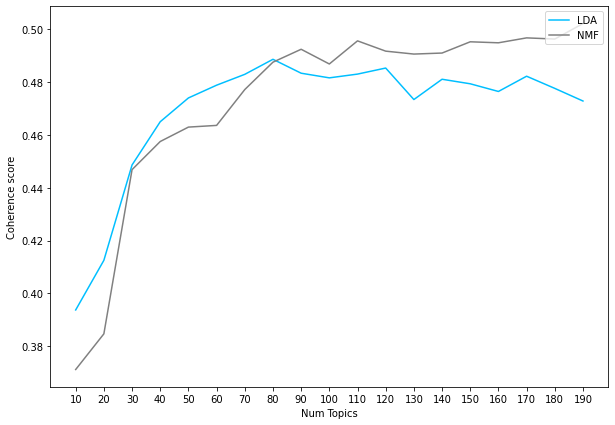

In [ ]:
#plot coherence
from matplotlib.pyplot import figure
figure(figsize=(10,7))
limit=200; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, coherence_values_lda,color = "deepskyblue", label='LDA')
plt.plot(x, coherence_values_nmf,color = "gray", label='NMF')
plt.legend(loc='upper right')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(x)
plt.show()

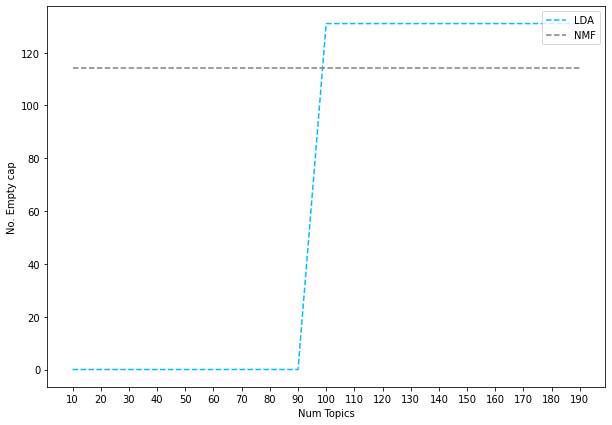

In [ ]:
# plot empty cap
figure(figsize=(10,7))
limit=200; start=10; step=10;
x = range(start, limit, step)
plt.plot(x, empty_document_lda,color = "deepskyblue", label = 'LDA',linestyle='dashed')
plt.plot(x, empty_document_nmf,color = "gray", label = 'NMF',linestyle='dashed')
plt.xlabel("Num Topics")
plt.ylabel("No. Empty cap")
plt.legend(loc='upper right')
plt.xticks(x)
plt.show()

In [ ]:
#more number of topics
coherence_values_lda = []
coherence_values_nmf = []
empty_document_lda=[]
empty_document_nmf=[]

#perplex=[]
model_list_lda = []
model_list_nmf = []
for num_topics in range(100,600,100):
    model_lda = ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42)
    model_list_lda.append(model_lda)
    coherencemodel_lda = CoherenceModel(model=model_lda, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values_lda.append(coherencemodel_lda.get_coherence())
    count_lda=0
    for i, row in enumerate(model_lda[corpus]):
        if row==[]:
            count_lda+=1
    empty_document_lda.append(count_lda)
    #perplex.append(model.log_perplexity(corpus))
    model_nmf =  nmf.Nmf(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42)
    model_list_nmf.append(model_nmf)
    coherencemodel_nmf = CoherenceModel(model=model_nmf, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_values_nmf.append(coherencemodel_nmf.get_coherence())
    count_nmf=0
    # check empty cap
    for i, row in enumerate(model_nmf[corpus]):
        if row==[]:
            count_nmf+=1
    empty_document_nmf.append(count_nmf)
    print (num_topics)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


100


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


200


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


300


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


400


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


500


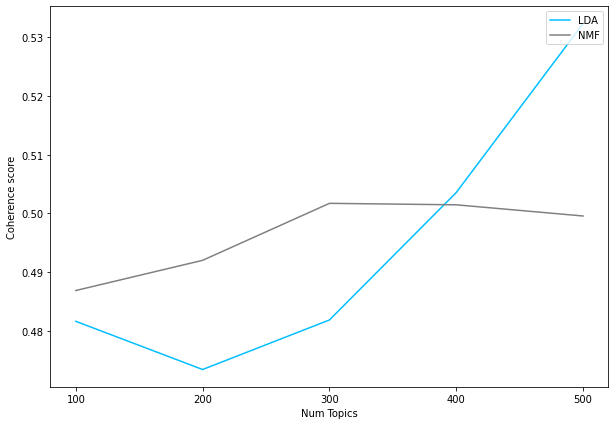

In [ ]:
#plot coherence
from matplotlib.pyplot import figure
figure(figsize=(10,7))
limit=600; start=100; step=100;
x = range(start, limit, step)
plt.plot(x, coherence_values_lda,color = "deepskyblue", label='LDA')
plt.plot(x, coherence_values_nmf,color = "gray", label='NMF')
plt.legend(loc='upper right')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(x)
plt.show()

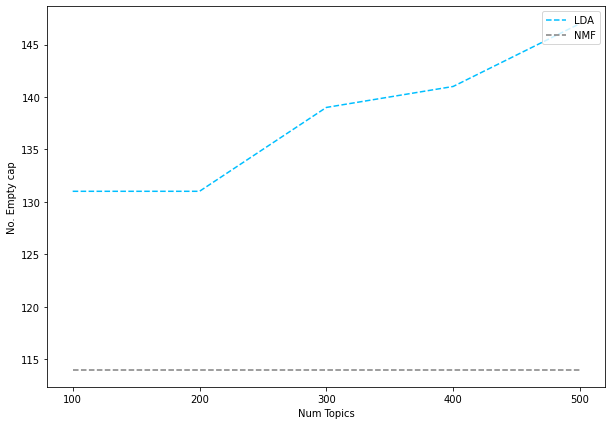

In [ ]:
# plot empty cap
figure(figsize=(10,7))
limit=600; start=100; step=100;
x = range(start, limit, step)
plt.plot(x, empty_document_lda,color = "deepskyblue", label = 'LDA',linestyle='dashed')
plt.plot(x, empty_document_nmf,color = "gray", label = 'NMF',linestyle='dashed')
plt.xlabel("Num Topics")
plt.ylabel("No. Empty cap")
plt.legend(loc='upper right')
plt.xticks(x)
plt.show()

In [ ]:
for i, j in zip(range(50,71),coherence_values_lda):
  print(i,j)

50 0.4815818537941666
51 0.47336833181954985
52 0.4818143894313444
53 0.5035460061264285
54 0.5323449301897072


## INVESTIGATE EMPTY CELL

In [ ]:
# apply topic model
model_nmf =  nmf.Nmf(corpus=corpus, num_topics=10, id2word=id2word, random_state=42)

In [ ]:
def format_topics_sentences(model_nmf, corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model_nmf[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # remove empty label
        if row ==[]:
          sent_topics_df = sent_topics_df.append(pd.Series([np.nan, np.nan, np.nan]), ignore_index=True)
        else:
          # Get the Dominant topic, Perc Contribution and Keywords for each document
          for j, (topic_num, prop_topic) in enumerate(row):
              if j == 0:  # => dominant topic
                  wp = model_nmf.show_topic(topic_num)
                  topic_keywords = ", ".join([word for word, prop in wp])
                  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
              else:
                  break
        
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    text=pd.Series(data_lemmatized)

    # Add original text to the end of the output
    new_caption_table = pd.concat([sent_topics_df, caption_table, text], axis=1)
    return(new_caption_table)


df_topic_sents_keywords = format_topics_sentences(model_nmf=model_nmf, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

In [ ]:
df_dominant_topic.head(50)

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,image_path,text,0
0,0,5.0,0.6740,"sit, ride, computer, desk, wooden, water, cove...",/content/train2014/COCO_train2014_000000521200...,A modern sink and shower stall are visible in ...,"[modern, sink, shower, stall, visible, photo]"
1,1,5.0,0.6496,"sit, ride, computer, desk, wooden, water, cove...",/content/train2014/COCO_train2014_000000573795...,A man riding a snowboard on snow covered ground.,"[ride, snow, cover, ground]"
2,2,3.0,0.4382,"next, train, man, track, tree, travel, station...",/content/train2014/COCO_train2014_000000254556...,A big pot of oil is holding donuts and holes a...,"[big, pot, oil, holding, donut, hole, fry]"
3,3,0.0,0.6274,"man, table, food, sit, lay, person, white, peo...",/content/train2014/COCO_train2014_000000449537...,A man riding a wave on top of a surfboard.,"[man, ride, surfboard]"
4,4,7.0,0.6416,"people, group, stand, sit, hold, small, man, f...",/content/train2014/COCO_train2014_000000188372...,two people riding skis on a snowy surface,"[people, ride, snowy, surface]"
5,5,4.0,0.7513,"sit, woman, glass, look, open, toilet, cat, wi...",/content/train2014/COCO_train2014_000000051735...,A little kid that is eating some food while si...,"[little, kid, eat, food, sit]"
6,6,9.0,0.9988,"stand, tennis, woman, water, man, hold, ball, ...",/content/train2014/COCO_train2014_000000024591...,A man skis down a slope at a snow resort.,[resort]
7,7,7.0,0.3739,"people, group, stand, sit, hold, small, man, f...",/content/train2014/COCO_train2014_000000295263...,A group of people sitting on couch next to a c...,"[group, people, sit, couch, next, coffee, table]"
8,8,2.0,0.7613,"young, walk, boy, hold, white, umbrella, plate...",/content/train2014/COCO_train2014_000000252178...,A hot dog confection is on top of a cake.,"[hot, dog, confection, cake]"
9,9,2.0,0.4701,"young, walk, boy, hold, white, umbrella, plate...",/content/train2014/COCO_train2014_000000223203...,Two adorable white dogs walking on a leash nex...,"[adorable, white, dog, walk, leash, next]"


In [ ]:
# find cap with empty label
df_dominant_topic[df_dominant_topic['Dominant_Topic'].isna()==True]

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,image_path,text,0
36,36,NaN,NaN,NaN,/content/train2014/COCO_train2014_000000119751...,A breakfast sandwich with eggs and bacon on to...,[]
147,147,NaN,NaN,NaN,/content/train2014/COCO_train2014_000000440349...,A man in white shirt doing a trick on a skateb...,[]
206,206,NaN,NaN,NaN,/content/train2014/COCO_train2014_000000448723...,Kitten on a bed sniffing a pepperoni pizza.,[]
225,225,NaN,NaN,NaN,/content/train2014/COCO_train2014_000000250084...,A blue and white mug and a kettle on a table i...,[]
235,235,NaN,NaN,NaN,/content/train2014/COCO_train2014_000000550094...,A big white animal is having some grass to mun...,[]
...,...,...,...,...,...,...,...
4783,4783,NaN,NaN,NaN,/content/train2014/COCO_train2014_000000258476...,A picture of some cars in the street.,[]
4865,4865,NaN,NaN,NaN,/content/train2014/COCO_train2014_000000318087...,a man is doing a trick on a skateboard,[]
4954,4954,NaN,NaN,NaN,/content/train2014/COCO_train2014_000000262691...,Bench on shore of river with a island in center,[]
4972,4972,NaN,NaN,NaN,/content/train2014/COCO_train2014_000000317690...,A stone clock tower overlooks a gray stone chu...,[]


In [ ]:
# take cap with empty label
unlabel=list(df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'].isna()==True,'index'])

In [ ]:
# take bigram
texts=[]
for i in unlabel:
  texts.append(data_words_bigrams[i])

In [ ]:
# check classification of word
for sent in texts:
    doc = nlp(" ".join(sent)) 
    print(doc)
    for i in doc:
      print (i.pos_)

# Result shown that caption with lots of nouns or no verb are detected to have pronoun only => no classification

breakfast sandwich eggs bacon top doughnut
PROPN
PROPN
PROPN
PROPN
PROPN
PROPN
man white shirt trick skateboard
PROPN
PROPN
PROPN
PROPN
PROPN
kitten bed sniffing pepperoni pizza
PROPN
PROPN
PROPN
PROPN
PROPN
blue white mug kettle table kitchen
PROPN
PROPN
PROPN
PROPN
PROPN
PROPN
big white animal grass munch
PROPN
PROPN
PROPN
PROPN
PROPN
zebras eating pen zoo
PROPN
PROPN
PROPN
X
trolley carrying microwave kitchen
PROPN
PROPN
PROPN
PROPN
white wireless keyboard mouse box
PROPN
PROPN
PROPN
PROPN
PROPN
street shot nyc lots neon
PROPN
PROPN
PROPN
PROPN
PROPN
modern open kitchen island middle
PROPN
PROPN
PROPN
PROPN
PROPN
woman standing doughnut
PROPN
PROPN
PROPN
father son kitchen preparing meal
PROPN
PROPN
PROPN
PROPN
PROPN
teen man jumps skateboard stairs park
PROPN
PROPN
PROPN
PROPN
PROPN
PROPN
man ramp snowboard
PROPN
PROPN
PROPN
policeman motorcycle orange cones
PROPN
PROPN
PROPN
PROPN
giraffe standing grass
PROPN
PROPN
PROPN
person standing street stop_sign
PROPN
PROPN
PROPN
PROPN
guy